# ML Zoomcamp 2023 – Second Capstone Project

This notebook uses the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs). First run the `make_dataset.py` file to download and extract the raw images.

In [1]:
import os
import re
import subprocess
from pathlib import Path
from time import time
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
try:
    import skimage
    print('Module skimage is installed.')
except ImportError:
    print('Module skimage is not installed, installing it now with pip.')
    p1 = subprocess.run('python -m pip install scikit-image -q', shell=True,
                        check=True, capture_output=True, text=True)
    if p1.stderr:
          print(p1.stderr)
    else:
        print('Installed scikit-image with pip.')
from skimage.io import imread
from skimage.transform import resize

Module skimage is not installed, installing it now with pip.
Installed scikit-image with pip.


In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img

In [6]:
images_dir = Path.cwd() / 'data/raw/Images'
annotation_dir = Path.cwd() / 'data/raw/Annotation'
processed_dir = Path.cwd() / 'data/processed'

## Data preparation

In [7]:
# folder names come from namimg in raw/Images and raw/Annotation folders
breed_dir_list_10 = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                     'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                     'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                     'n02111129-Leonberg']

In [8]:
breed_dir_list_30 = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                     'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                     'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                     'n02111129-Leonberg', 'n02110806-basenji', 'n02097474-Tibetan_terrier',
                     'n02108000-EntleBucher', 'n02095889-Sealyham_terrier', 'n02096051-Airedale',
                     'n02110958-pug', 'n02091831-Saluki', 'n02095570-Lakeland_terrier', 'n02096177-cairn',
                     'n02086910-papillon', 'n02112137-chow', 'n02091467-Norwegian_elkhound',
                     'n02096294-Australian_terrier', 'n02088364-beagle', 'n02111277-Newfoundland',
                     'n02110185-Siberian_husky', 'n02086646-Blenheim_spaniel', 'n02099601-golden_retriever',
                     'n02099712-Labrador_retriever', 'n02085620-Chihuahua']

In [12]:
# modified from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook
breed_dir_list = os.listdir(images_dir)
if not processed_dir.exists():
    Path.mkdir(processed_dir, exist_ok=True)
    for breed_dir in breed_dir_list:
        breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
        breed_name = re.sub(r'-', r'_', breed_name.lower())
        Path.mkdir(processed_dir / breed_name, exist_ok=True)
    print(f'''Created {len(os.listdir(processed_dir))} folders to store cropped images of the different breeds.''')
else:
    print(f'Folder {processed_dir} already exists.')

Created 120 folders to store cropped images of the different breeds.


In [13]:
t0 = time()
img_size = 299
print(f'Saving {img_size}x{img_size} image sizes.')
if not list(processed_dir.glob('**/*.jpg')):
    for breed_dir in breed_dir_list:
        counter = 0
        for breed_prefix in os.listdir(f'{annotation_dir}/{breed_dir}'):
            img = Image.open(f'{images_dir}/{breed_dir}/{breed_prefix}.jpg')
            tree = ET.parse(f'{annotation_dir}/{breed_dir}/{breed_prefix}')
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((img_size, img_size))
            breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
            breed_name = re.sub(r'-', r'_', breed_name.lower())
            img.save(str(processed_dir) + '/' + breed_name + '/' + breed_prefix + '.jpg')
            counter += 1
        print(f'Saved {counter} images in {breed_name} folder.')
    print(f'Time elapsed: {round(time()-t0, 0)} seconds.')
else:
    print(f'Folder {str(processed_dir)} with cropped images already exists.')

Saving 299x299 image sizes.
Saved 155 images in standard_schnauzer folder.
Saved 156 images in bull_mastiff folder.
Saved 202 images in sealyham_terrier folder.
Saved 150 images in clumber folder.
Saved 153 images in walker_hound folder.
Saved 150 images in eskimo_dog folder.
Saved 169 images in african_hunting_dog folder.
Saved 239 images in afghan_hound folder.
Saved 159 images in standard_poodle folder.
Saved 149 images in pekinese folder.
Saved 187 images in whippet folder.
Saved 164 images in american_staffordshire_terrier folder.
Saved 157 images in english_foxhound folder.
Saved 181 images in pembroke folder.
Saved 196 images in chow folder.
Saved 185 images in japanese_spaniel folder.
Saved 152 images in german_short_haired_pointer folder.
Saved 182 images in bedlington_terrier folder.
Saved 153 images in collie folder.
Saved 150 images in irish_water_spaniel folder.
Saved 153 images in brabancon_griffon folder.
Saved 210 images in leonberg folder.
Saved 152 images in tibetan_m

### Removal of corrupted images

In [14]:
num_skipped = 0
for folder_name in breed_dir_list:
    folder_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', str(folder_name))
    folder_name = re.sub(r'-', r'_', folder_name.lower())
    breed_dir = processed_dir / folder_name
    print(f'Looking into folder {str(breed_dir)}')
    for fname in os.listdir(breed_dir):
        fpath = breed_dir / fname
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/standard_schnauzer
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/bull_mastiff
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/sealyham_terrier
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/clumber
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/walker_hound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/eskimo_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/african_hunting_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/afghan_hound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/standard_poodle
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/pekinese
L

## Pre-trained convolutional neural networks

In [15]:
model = Xception(weights='imagenet', input_shape=(img_size, img_size, 3))

In [16]:
path_to_image = 'data/processed/scottish_deerhound/n02092002_109.jpg'
img = load_img(path_to_image, target_size=(img_size, img_size))
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 2s 2s/step


[[('n02092002', 'Scottish_deerhound', 0.7939886),
  ('n02090721', 'Irish_wolfhound', 0.04308381),
  ('n02090622', 'borzoi', 0.005164035),
  ('n02091244', 'Ibizan_hound', 0.003001548),
  ('n02100236', 'German_short-haired_pointer', 0.0029592125)]]

## Data generation

In [17]:
new_img_size = 150
image_size_tuple = (new_img_size, new_img_size)
batch_size = 32

In [18]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    processed_dir,
    validation_split = 0.3,
    subset = 'both',
    seed = 33,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = image_size_tuple,
    batch_size = batch_size,
    shuffle=True,
)

Found 20580 files belonging to 120 classes.
Using 14406 files for training.
Using 6174 files for validation.


In [19]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((1*val_batches) // 2)
val_ds = val_ds.skip((1*val_batches) // 2)

### Data visualization

In [20]:
names = train_ds.class_names

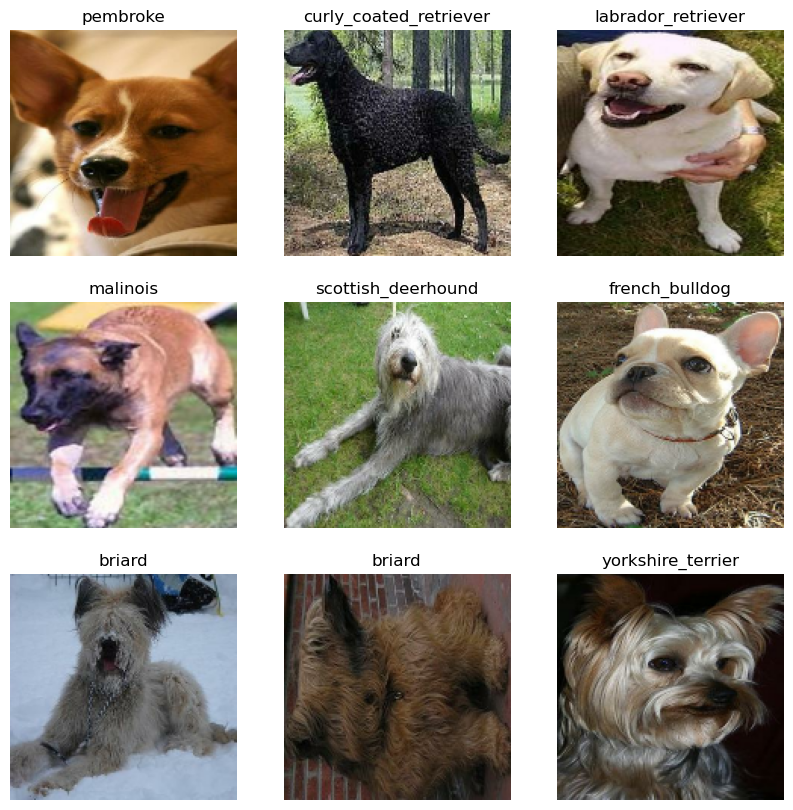

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(names[list(labels[i]).index(1)])
        plt.axis('off')

## Transfer learning

Using a small image size to decrease training time.

In [25]:
num_layers = 120 # number of layers must be equal to the number of groups of images
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(num_layers)(vectors)
model = keras.Model(inputs, outputs)

In [26]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [27]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
  1/451 [..............................] - ETA: 30:25 - loss: 34.0356 - accuracy: 0.0000e+00

I0000 00:00:1709382562.985276    3534 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


451/451 [==============================] - 36s 72ms/step - loss: 76.3286 - accuracy: 0.0349 - val_loss: 77.0608 - val_accuracy: 0.0335
Epoch 2/10
451/451 [==============================] - 29s 65ms/step - loss: 66.9533 - accuracy: 0.0631 - val_loss: 78.4728 - val_accuracy: 0.0435
Epoch 3/10
451/451 [==============================] - 29s 65ms/step - loss: 65.1410 - accuracy: 0.0911 - val_loss: 90.5829 - val_accuracy: 0.0371
Epoch 4/10
451/451 [==============================] - 29s 65ms/step - loss: 60.9936 - accuracy: 0.1149 - val_loss: 85.7839 - val_accuracy: 0.0516
Epoch 5/10
451/451 [==============================] - 29s 65ms/step - loss: 59.5195 - accuracy: 0.1385 - val_loss: 93.7648 - val_accuracy: 0.0538
Epoch 6/10
451/451 [==============================] - 29s 65ms/step - loss: 58.3902 - accuracy: 0.1565 - val_loss: 91.6536 - val_accuracy: 0.0529
Epoch 7/10
451/451 [==============================] - 30s 65ms/step - loss: 56.5306 - accuracy: 0.1716 - val_loss: 94.3486 - val_accura

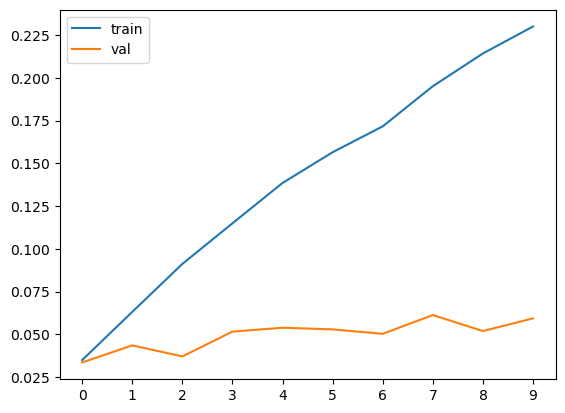

In [28]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Data augmentation

In [29]:
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

In [30]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

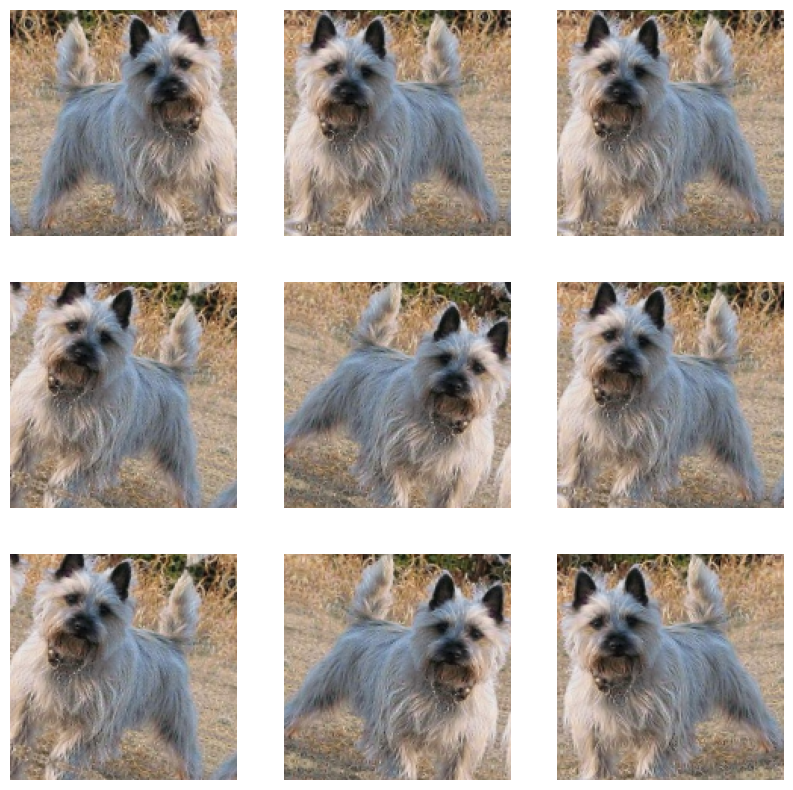

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [32]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
augmented_inputs = data_augmentation(inputs)
scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
base = base_model(scaled_inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(num_layers)(vectors)
model = keras.Model(inputs, outputs)

In [33]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [34]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
451/451 [==============================] - 34s 69ms/step - loss: 4.7346 - accuracy: 0.5563 - val_loss: 3.3682 - val_accuracy: 0.7050
Epoch 2/10
451/451 [==============================] - 31s 68ms/step - loss: 4.2687 - accuracy: 0.6523 - val_loss: 3.9876 - val_accuracy: 0.6941
Epoch 3/10
451/451 [==============================] - 31s 68ms/step - loss: 4.1020 - accuracy: 0.6792 - val_loss: 3.9315 - val_accuracy: 0.7157
Epoch 4/10
451/451 [==============================] - 31s 68ms/step - loss: 3.8630 - accuracy: 0.6959 - val_loss: 4.3648 - val_accuracy: 0.7141
Epoch 5/10
451/451 [==============================] - 31s 68ms/step - loss: 3.7188 - accuracy: 0.7171 - val_loss: 4.7081 - val_accuracy: 0.7279
Epoch 6/10
451/451 [==============================] - 31s 68ms/step - loss: 3.5264 - accuracy: 0.7332 - val_loss: 5.1151 - val_accuracy: 0.7102
Epoch 7/10
451/451 [==============================] - 31s 68ms/step - loss: 3.3101 - accuracy: 0.7520 - val_loss: 5.2701 - val_accuracy:

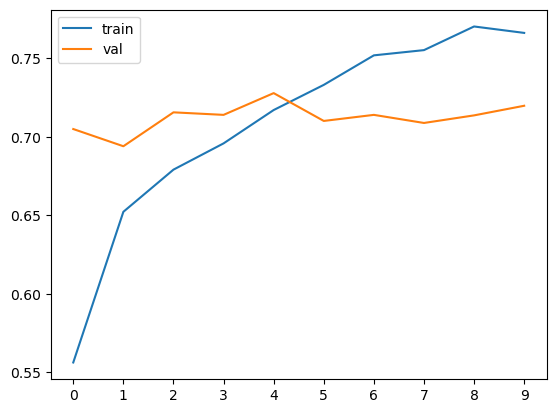

In [35]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Tuning the learning rate

In [36]:
def make_model(learning_rate=0.01, num_layers=120):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(num_layers)(vectors)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [37]:
learning_rate_scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f'Learning rate: {lr}')
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    learning_rate_scores[lr] = history.history
    print()
    print('*****'*10)
    print()

Learning rate: 0.0001
Epoch 1/10
451/451 [==============================] - 34s 69ms/step - loss: 2.6444 - accuracy: 0.4433 - val_loss: 1.2351 - val_accuracy: 0.7263
Epoch 2/10
451/451 [==============================] - 31s 68ms/step - loss: 1.2641 - accuracy: 0.6751 - val_loss: 0.8691 - val_accuracy: 0.7640
Epoch 3/10
451/451 [==============================] - 31s 68ms/step - loss: 1.0491 - accuracy: 0.7110 - val_loss: 0.7752 - val_accuracy: 0.7805
Epoch 4/10
451/451 [==============================] - 31s 68ms/step - loss: 0.9562 - accuracy: 0.7264 - val_loss: 0.7363 - val_accuracy: 0.7798
Epoch 5/10
451/451 [==============================] - 31s 68ms/step - loss: 0.9166 - accuracy: 0.7318 - val_loss: 0.7148 - val_accuracy: 0.7869
Epoch 6/10
451/451 [==============================] - 31s 68ms/step - loss: 0.8626 - accuracy: 0.7457 - val_loss: 0.7036 - val_accuracy: 0.7847
Epoch 7/10
451/451 [==============================] - 31s 68ms/step - loss: 0.8327 - accuracy: 0.7485 - val_loss: 

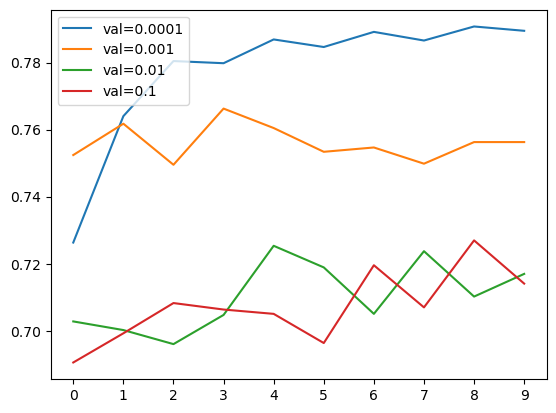

In [38]:
for lr, hist in learning_rate_scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(10))
plt.legend()

## Adjusting inner layers

In [39]:
def make_model(learning_rate=0.01, size_inner=100, num_layers=120):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(num_layers)(inner)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [40]:
best_learning_rate = 0.0001
size_scores = {}
for size in [10, 100, 1000]:
    print(f'Inner layer size: {size}')
    model = make_model(learning_rate=best_learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    size_scores[size] = history.history
    print()
    print('*****'*10)
    print()

Inner layer size: 10
Epoch 1/10
451/451 [==============================] - 34s 69ms/step - loss: 4.6288 - accuracy: 0.0343 - val_loss: 4.3514 - val_accuracy: 0.0880
Epoch 2/10
451/451 [==============================] - 31s 68ms/step - loss: 4.1796 - accuracy: 0.1155 - val_loss: 3.8710 - val_accuracy: 0.1863
Epoch 3/10
451/451 [==============================] - 31s 68ms/step - loss: 3.7301 - accuracy: 0.2070 - val_loss: 3.3869 - val_accuracy: 0.2724
Epoch 4/10
451/451 [==============================] - 31s 68ms/step - loss: 3.2869 - accuracy: 0.2811 - val_loss: 2.9237 - val_accuracy: 0.3466
Epoch 5/10
451/451 [==============================] - 31s 68ms/step - loss: 2.8803 - accuracy: 0.3512 - val_loss: 2.5450 - val_accuracy: 0.4220
Epoch 6/10
451/451 [==============================] - 31s 68ms/step - loss: 2.5921 - accuracy: 0.4056 - val_loss: 2.2682 - val_accuracy: 0.4768
Epoch 7/10
451/451 [==============================] - 31s 68ms/step - loss: 2.3752 - accuracy: 0.4451 - val_loss: 2

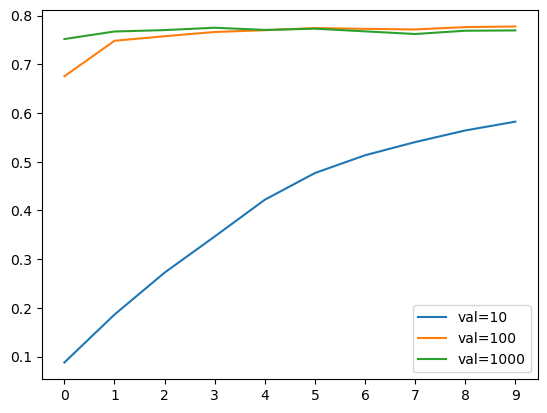

In [41]:
for size, hist in size_scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.xticks(np.arange(10))
# plt.ylim(0.90, 0.95)
plt.legend()

## Adding dropout

In [42]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5, num_layers=120):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(num_layers)(drop)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [43]:
best_learning_rate = 0.0001
best_size = 1000
droprate_scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(f'Dropout rate: {droprate}')
    model = make_model(learning_rate=best_learning_rate, size_inner=best_size, droprate=droprate)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    droprate_scores[droprate] = history.history
    print()
    print('*****'*10)
    print()

Dropout rate: 0.0
Epoch 1/30
451/451 [==============================] - 34s 69ms/step - loss: 1.7846 - accuracy: 0.5836 - val_loss: 0.7884 - val_accuracy: 0.7689
Epoch 2/30
451/451 [==============================] - 31s 68ms/step - loss: 1.0040 - accuracy: 0.7087 - val_loss: 0.7444 - val_accuracy: 0.7714
Epoch 3/30
451/451 [==============================] - 31s 68ms/step - loss: 0.9066 - accuracy: 0.7307 - val_loss: 0.7332 - val_accuracy: 0.7714
Epoch 4/30
451/451 [==============================] - 31s 68ms/step - loss: 0.8474 - accuracy: 0.7482 - val_loss: 0.7247 - val_accuracy: 0.7721
Epoch 5/30
451/451 [==============================] - 31s 68ms/step - loss: 0.7841 - accuracy: 0.7642 - val_loss: 0.7338 - val_accuracy: 0.7724
Epoch 6/30
451/451 [==============================] - 31s 69ms/step - loss: 0.7414 - accuracy: 0.7729 - val_loss: 0.7334 - val_accuracy: 0.7776
Epoch 7/30
451/451 [==============================] - 31s 69ms/step - loss: 0.7029 - accuracy: 0.7833 - val_loss: 0.73

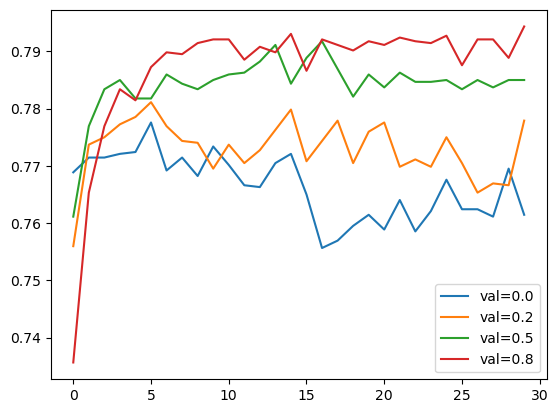

In [44]:
for droprate, hist in droprate_scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
# plt.ylim(0.86, 0.95)
plt.legend(loc=4)

## Saving best model with checkpointing

In [45]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [46]:
learning_rate = 0.0001
size = 1000
droprate = 0.8
model = make_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)

In [47]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/50
450/451 [============================>.] - ETA: 0s - loss: 3.5183 - accuracy: 0.2514

/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


451/451 [==============================] - 35s 70ms/step - loss: 3.5177 - accuracy: 0.2515 - val_loss: 1.2270 - val_accuracy: 0.7402
Epoch 2/50
451/451 [==============================] - 31s 69ms/step - loss: 1.8984 - accuracy: 0.5296 - val_loss: 0.8400 - val_accuracy: 0.7692
Epoch 3/50
451/451 [==============================] - 31s 69ms/step - loss: 1.5869 - accuracy: 0.5923 - val_loss: 0.7703 - val_accuracy: 0.7792
Epoch 4/50
451/451 [==============================] - 31s 69ms/step - loss: 1.4629 - accuracy: 0.6162 - val_loss: 0.7413 - val_accuracy: 0.7847
Epoch 5/50
451/451 [==============================] - 31s 69ms/step - loss: 1.3877 - accuracy: 0.6313 - val_loss: 0.7267 - val_accuracy: 0.7814
Epoch 6/50
451/451 [==============================] - 31s 69ms/step - loss: 1.3103 - accuracy: 0.6457 - val_loss: 0.7168 - val_accuracy: 0.7869
Epoch 7/50
451/451 [==============================] - 31s 69ms/step - loss: 1.2612 - accuracy: 0.6567 - val_loss: 0.7102 - val_accuracy: 0.7869
Epo

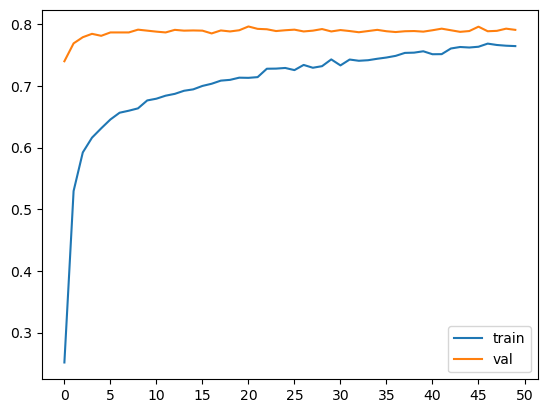

In [48]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.linspace(0, 50, 11))
plt.legend()

## Testing the model

In [49]:
best_model = keras.models.load_model('xception_v1_21_0.797.h5')

In [50]:
loss, test_acc = best_model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

96/96 [==============================] - 6s 52ms/step - loss: 0.6628 - accuracy: 0.7992
Test accuracy: 0.7992


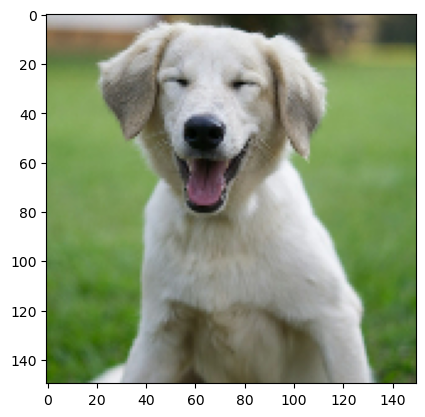

In [51]:
path_to_image = '/home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/test/great_pyrenees.jpg'
img = keras.utils.load_img(path_to_image, target_size=image_size_tuple)
plt.imshow(img)

In [52]:
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

In [53]:
predictions = best_model.predict(img_array)

1/1 [==============================] - 1s 1s/step


In [54]:
dict(zip(names, predictions[0]))

{'affenpinscher': -4.1823635,
 'afghan_hound': -3.256772,
 'african_hunting_dog': -4.760918,
 'airedale': -3.4016242,
 'american_staffordshire_terrier': -3.0127184,
 'appenzeller': -3.2638044,
 'australian_terrier': -4.8475194,
 'basenji': -3.9650254,
 'basset': -4.8870807,
 'beagle': -3.54148,
 'bedlington_terrier': -4.112714,
 'bernese_mountain_dog': -3.7962053,
 'black_and_tan_coonhound': -3.6738558,
 'blenheim_spaniel': -5.1831837,
 'bloodhound': -4.0619597,
 'bluetick': -4.5654984,
 'border_collie': -2.130147,
 'border_terrier': -4.697259,
 'borzoi': -2.191238,
 'boston_bull': -5.804509,
 'bouvier_des_flandres': -5.119423,
 'boxer': -3.859904,
 'brabancon_griffon': -4.442572,
 'briard': -3.2308807,
 'brittany_spaniel': -2.1572824,
 'bull_mastiff': -4.3120494,
 'cairn': -4.4023104,
 'cardigan': -3.992044,
 'chesapeake_bay_retriever': -2.398853,
 'chihuahua': -4.45029,
 'chow': -3.6119978,
 'clumber': -3.4499066,
 'cocker_spaniel': -2.7184036,
 'collie': -2.1241474,
 'curly_coated_r

In [55]:
breed_df = pd.Series(dict(zip(names, predictions[0])))
breed_df.sort_values(ascending=False, inplace=True)
breed_df.head(6)

golden_retriever         3.294624
kuvasz                   1.935739
great_pyrenees           1.550170
labrador_retriever       1.505579
english_setter          -0.741654
flat_coated_retriever   -1.168444
dtype: float32